In [3]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

In [4]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

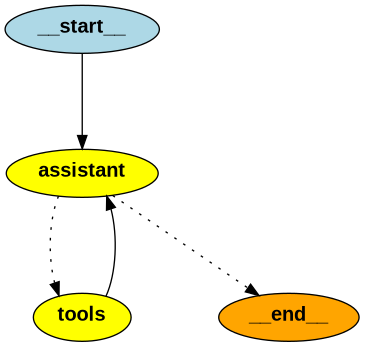

In [6]:

system_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["assistant"], checkpointer=memory)
display(Image(graph.get_graph(xray=True).draw_png()))

In [7]:
initial_input = {"messages": "Multiply 2 and 3"}

config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [8]:
state = graph.get_state(config)
state

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='b6fb5377-4184-4a8f-8f48-601d1a5f1073')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05d952-9930-6671-8000-129ffd3de697'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-07-10T13:52:47.749681+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05d952-992e-6157-bfff-24f1941228e3'}}, tasks=(PregelTask(id='5c13288d-c7ad-71b1-22c7-cd9b2efae45a', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [9]:
graph.update_state(
    config,
    {"messages": [HumanMessage(content="No, actually multiply 3 and 3!")]},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05d954-3918-6bed-8001-03268e60bedd'}}

In [10]:
new_state = graph.get_state(config).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No, actually multiply 3 and 3!


In [11]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, actually multiply 3 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QiVchNpvKg9jX6ng5xOx9k4q)
 Call ID: call_QiVchNpvKg9jX6ng5xOx9k4q
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9


In [12]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of multiplying 3 by 3 is 9.


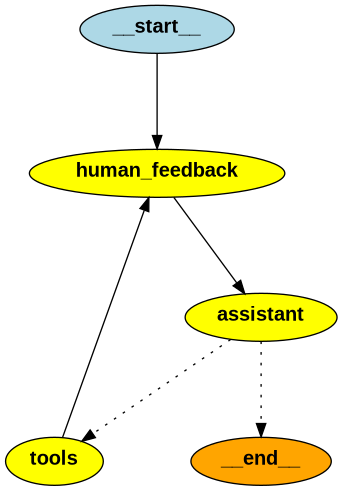

In [14]:
system_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "human_feedback")
builder.add_edge("human_feedback", "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "human_feedback")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_png()))

In [15]:
initial_input = {"messages": "Multiply 2 and 3"}

config = {"configurable": {"thread_id": "5"}}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

user_input = input("Tell me how you want to update the state: ")
graph.update_state(config, {"messages": user_input}, as_node="human_feedback")

for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No. Multiply 3 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_JuITPDPmdxlOntS4y6kpa6Pc)
 Call ID: call_JuITPDPmdxlOntS4y6kpa6Pc
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: multiply

12


In [16]:
for event in graph.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

12
================================== Ai Message ==================================

The product of 3 and 4 is 12.
